In [2]:
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
from scipy.integrate import trapz
from scipy.signal import find_peaks

# Import Data

In [3]:
%store -r acc_dict
person_names = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18"]

In [4]:
features = pd.read_excel('features.xlsx')
start = np.array(features['from_imu']).astype(int)
end = np.array(features['to_imu']).astype(int)
exploratory = np.array(features['exploratory'])
performance = np.array(features['performance'])
double = np.array(features['double'])

section_dict = {}
for i, person_name in enumerate(person_names):
    acc_dataset = acc_dict[person_name]
    total_time = acc_dataset['time']

    acc_dataset['grasping_exploratory'] = exploratory[i]
    acc_dataset['grasping_performance'] = performance[i]
    acc_dataset['grasping_double'] = double[i]
    section_dict[person_name] = {'start': start[i], 'end': end[i], 'time_1': np.arange(1, start[i]), 'time_2': np.arange(start[i], end[i]), 'time_3': np.arange(end[i], len(total_time) - 1)}

# Section Extraction
Section 1 - 3 for all axes and the vector of the jerk value

In [5]:
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    start = section_dict[person_name]['start']
    end = section_dict[person_name]['end']

    acc_dataset['section_1_x_jerk_normalized_global'] = acc_dataset['acc_x_derivative_normalized_global'][0:start]
    acc_dataset['section_2_x_jerk_normalized_global'] = acc_dataset['acc_x_derivative_normalized_global'][start:end]
    acc_dataset['section_3_x_jerk_normalized_global'] = acc_dataset['acc_x_derivative_normalized_global'][end:-1]
    acc_dataset['section_1_y_jerk_normalized_global'] = acc_dataset['acc_y_derivative_normalized_global'][0:start]
    acc_dataset['section_2_y_jerk_normalized_global'] = acc_dataset['acc_y_derivative_normalized_global'][start:end]
    acc_dataset['section_3_y_jerk_normalized_global'] = acc_dataset['acc_y_derivative_normalized_global'][end:-1]
    acc_dataset['section_1_z_jerk_normalized_global'] = acc_dataset['acc_z_derivative_normalized_global'][0:start]
    acc_dataset['section_2_z_jerk_normalized_global'] = acc_dataset['acc_z_derivative_normalized_global'][start:end]
    acc_dataset['section_3_z_jerk_normalized_global'] = acc_dataset['acc_z_derivative_normalized_global'][end:-1]
    acc_dataset['section_1_vector_jerk_normalized_global'] = acc_dataset['jerk_vector_normalized_global'][0:start]
    acc_dataset['section_2_vector_jerk_normalized_global'] = acc_dataset['jerk_vector_normalized_global'][start:end]
    acc_dataset['section_3_vector_jerk_normalized_global'] = acc_dataset['jerk_vector_normalized_global'][end:-1]


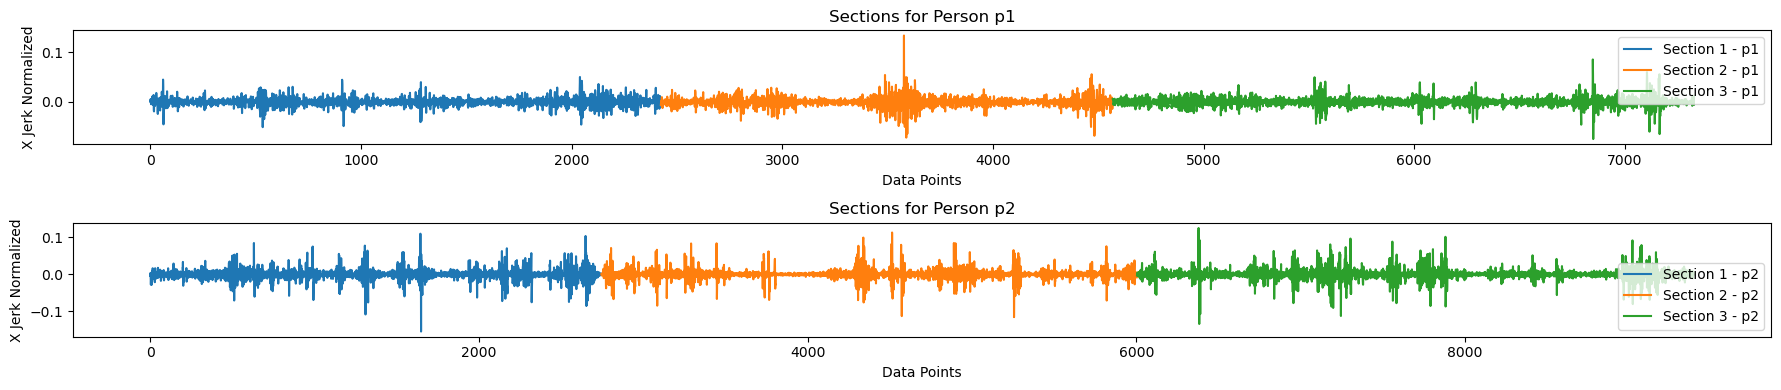

In [6]:
# Extract the data for person p1
p1_section1 = acc_dict['p1']['section_1_vector_jerk_normalized_global']
p1_section2 = acc_dict['p1']['section_2_vector_jerk_normalized_global']
p1_section3 = acc_dict['p1']['section_3_vector_jerk_normalized_global']

# Extract the data for person p2
p2_section1 = acc_dict['p2']['section_1_vector_jerk_normalized_global']
p2_section2 = acc_dict['p2']['section_2_vector_jerk_normalized_global']
p2_section3 = acc_dict['p2']['section_3_vector_jerk_normalized_global']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 4))

# Plot data for person p1
ax1.plot(p1_section1, label='Section 1 - p1')
ax1.plot(p1_section2, label='Section 2 - p1')
ax1.plot(p1_section3, label='Section 3 - p1')
ax1.set_title('Sections for Person p1')
ax1.set_xlabel('Data Points')
ax1.set_ylabel('X Jerk Normalized')
ax1.legend()

# Plot data for person p2
ax2.plot(p2_section1, label='Section 1 - p2')
ax2.plot(p2_section2, label='Section 2 - p2')
ax2.plot(p2_section3, label='Section 3 - p2')
ax2.set_title('Sections for Person p2')
ax2.set_xlabel('Data Points')
ax2.set_ylabel('X Jerk Normalized')
ax2.legend()

plt.tight_layout()
plt.show()


# Mean Squared Jerk
Computation for all axes and the vector for all sections

In [7]:
jerk_values = {'section_1_x': {}, 'section_1_y': {}, 'section_1_z': {}, 'section_1_vector': {}, 
               'section_2_x': {}, 'section_2_y': {}, 'section_2_z': {}, 'section_2_vector': {}, 
               'section_3_x': {}, 'section_3_y': {}, 'section_3_z': {}, 'section_3_vector': {}}

for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    section_dataset = section_dict[person_name]
    time = acc_dataset['time']
    time_1 = section_dataset['time_1']
    time_2 = section_dataset['time_2']
    time_3 = section_dataset['time_3']
    start_section_2 = len(time_1) + 1
    start_section_3 = len(time_1) + len(time_2) + 1
    
    for axis in ['x', 'y', 'z', 'vector']:
        section1 = acc_dataset[f'section_1_{axis}_jerk_normalized_global'][0:len(time_1)]
        section2 = acc_dataset[f'section_2_{axis}_jerk_normalized_global'][start_section_2  : start_section_3]
        section3 = acc_dataset[f'section_3_{axis}_jerk_normalized_global'][start_section_3 : len(time_1) + len(time_2) + len(time_3) + 1]
        
        # Integrate 
        integral_value_1 = trapz(np.abs(section1), time_1)
        integral_value_2 = trapz(np.abs(section2), time_2)
        integral_value_3 = trapz(np.abs(section3), time_3)
        mean_jerk_1 = (1 / len(time_1)) * integral_value_1
        mean_jerk_2 = (1 / len(time_2)) * integral_value_2
        mean_jerk_3 = (1 / len(time_3)) * integral_value_3

        jerk_values[f'section_1_{axis}'][person_name] = mean_jerk_1
        jerk_values[f'section_2_{axis}'][person_name] = mean_jerk_2
        jerk_values[f'section_3_{axis}'][person_name] = mean_jerk_3

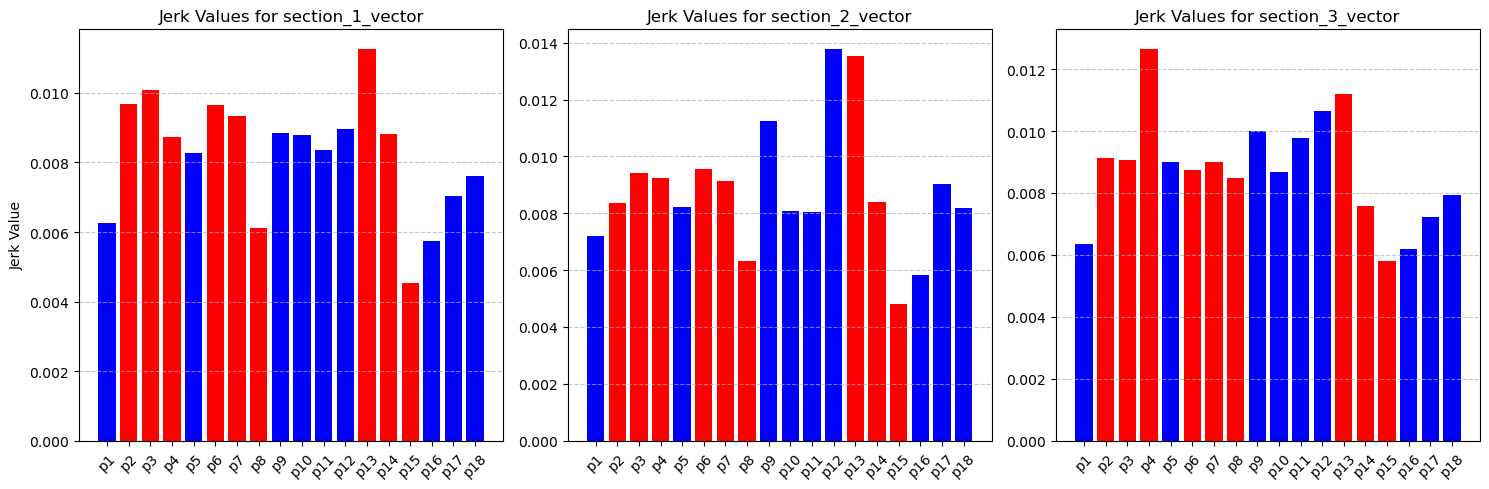

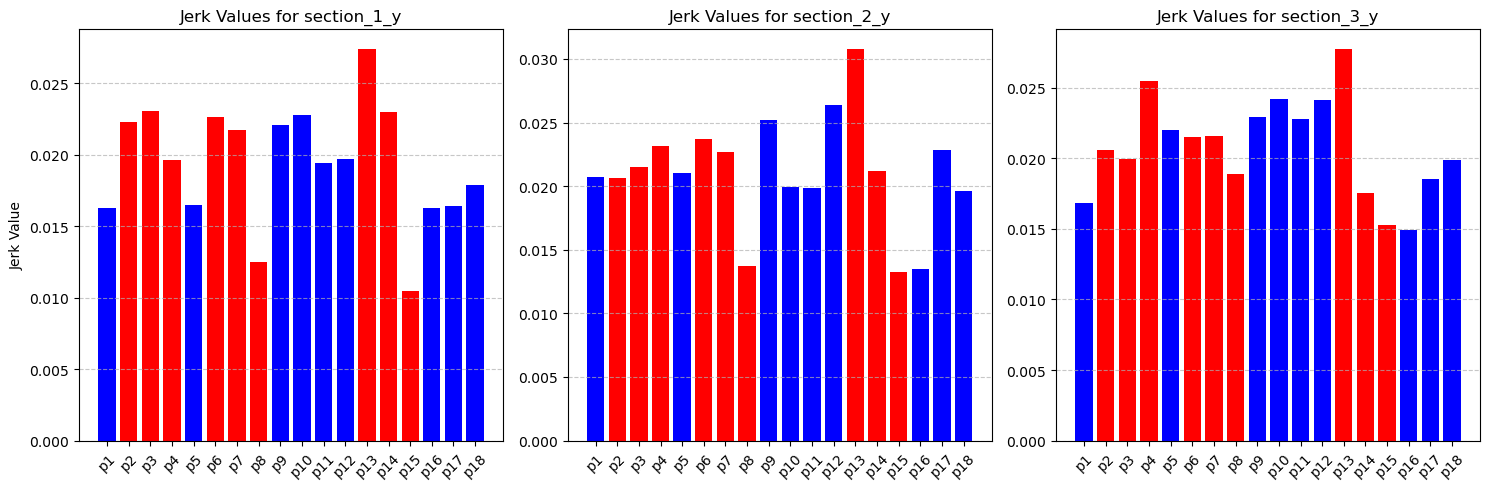

In [8]:
axes = ['section_1_vector', 'section_2_vector', 'section_3_vector']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, axis in enumerate(axes):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

axs[0].set_ylabel('Jerk Value')
plt.tight_layout()
plt.show()

axes_x = ['section_1_y', 'section_2_y', 'section_3_y']
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, axis in enumerate(axes_x):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

axs[0].set_ylabel('Jerk Value')
plt.tight_layout()
plt.show()

In [9]:
jerk_values_women = {'section_1_x': [], 'section_1_y': [], 'section_1_z': [], 'section_1_vector': [], 
                     'section_2_x': [], 'section_2_y': [], 'section_2_z': [], 'section_2_vector': [], 
                     'section_3_x': [], 'section_3_y': [], 'section_3_z': [], 'section_3_vector': []}
jerk_values_men = {'section_1_x': [], 'section_1_y': [], 'section_1_z': [], 'section_1_vector': [], 
                   'section_2_x': [], 'section_2_y': [], 'section_2_z': [], 'section_2_vector': [], 
                   'section_3_x': [], 'section_3_y': [], 'section_3_z': [], 'section_3_vector': []}

for axis, values in jerk_values.items():
    person_names = list(values.keys())
    values = list(values.values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    for person_name, jerk_value, gender in zip(person_names, values, genders):
        if gender == 'female':
            jerk_values_women[axis].append(jerk_value)
        elif gender == 'male':
            jerk_values_men[axis].append(jerk_value)

mean_jerk_values_women = {axis: np.mean(values) for axis, values in jerk_values_women.items()}
std_jerk_values_women = {axis: np.std(values) for axis, values in jerk_values_women.items()}
mean_jerk_values_men = {axis: np.mean(values) for axis, values in jerk_values_men.items()}
std_jerk_values_men = {axis: np.std(values) for axis, values in jerk_values_men.items()}

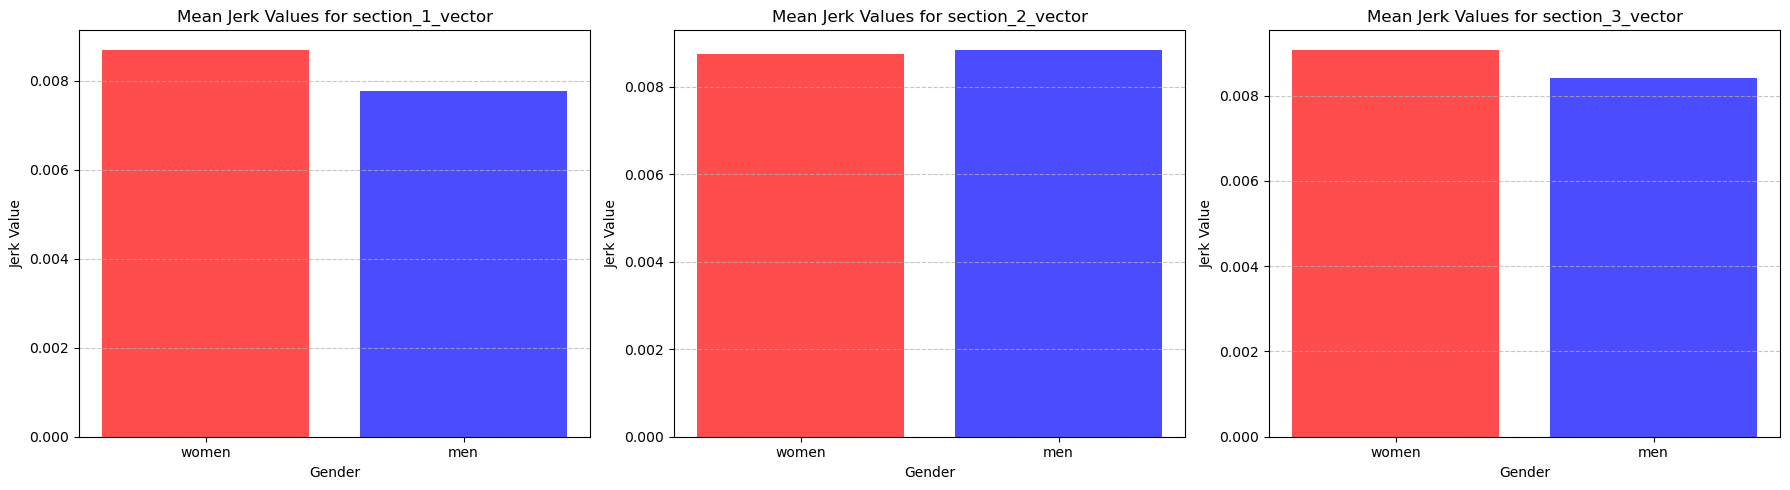

In [10]:
axes = ['section_1_vector', 'section_2_vector', 'section_3_vector']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, axis in enumerate(axes):
    x_labels = ['women', 'men']
    x = range(len(x_labels))
    y_mean_values = [mean_jerk_values_women[axis], mean_jerk_values_men[axis]]
    y_std_values = [std_jerk_values_women[axis], std_jerk_values_men[axis]]
    
    # Define the colors for women and men
    colors = ['red', 'blue']
    axs[i].bar(x, y_mean_values, color=colors, alpha=0.7, capsize=5)
    
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(x_labels)
    axs[i].set_xlabel('Gender')
    axs[i].set_ylabel('Jerk Value')
    axs[i].set_title(f'Mean Jerk Values for {axis}')
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

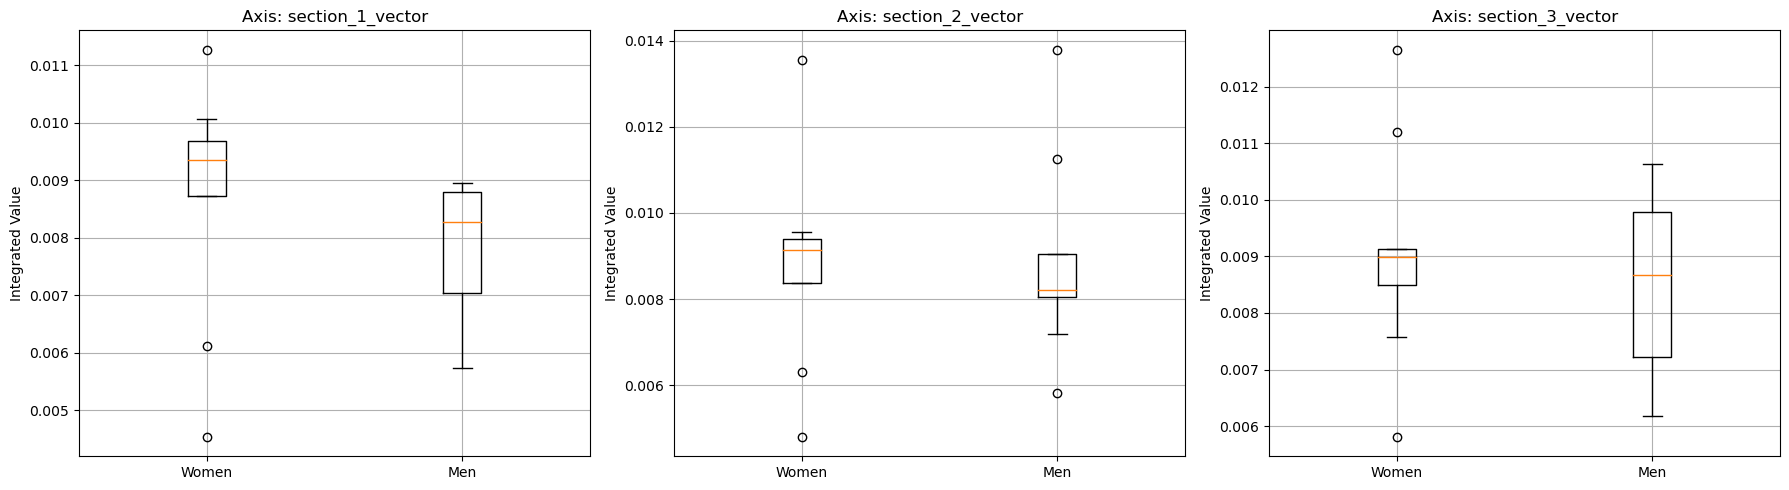

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, axis in enumerate(['section_1_vector', 'section_2_vector', 'section_3_vector']):
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]

    plot_jerk_values_women = [values[j] for j, gender in enumerate(genders) if gender == 'female']
    plot_jerk_values_men = [values[j] for j, gender in enumerate(genders) if gender == 'male']
    
    positions = [1, 2]
    axs[i].boxplot([plot_jerk_values_women, plot_jerk_values_men], positions=positions, labels=['Women', 'Men'])
    axs[i].set_ylabel('Integrated Value')
    axs[i].set_title(f'Axis: {axis}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Feature Peaks

In [12]:
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    section1 = acc_dataset['section_1_vector_jerk_normalized_global']
    section2 = acc_dataset['section_2_vector_jerk_normalized_global']
    section3 = acc_dataset['section_3_vector_jerk_normalized_global']
    
    max1 = np.max(np.abs(section1))
    max2 = np.max(np.abs(section2))
    max3 = np.max(np.abs(section3))
    
    section1_normalized = section1 / max1
    section2_normalized = section2 / max2
    section3_normalized = section3 / max3
    
    acc_dataset['section_1_normalized'] = section1_normalized
    acc_dataset['section_2_normalized'] = section2_normalized
    acc_dataset['section_3_normalized'] = section3_normalized

Mean value for section_1: 0.35239256130300034
Number of positive peaks in section_1: 54
Number of negative peaks in section_1: 45
Mean value for section_2: 0.23244267980752392
Number of positive peaks in section_2: 14
Number of negative peaks in section_2: 19
Mean value for section_3: 0.2730106375740371
Number of positive peaks in section_3: 26
Number of negative peaks in section_3: 25


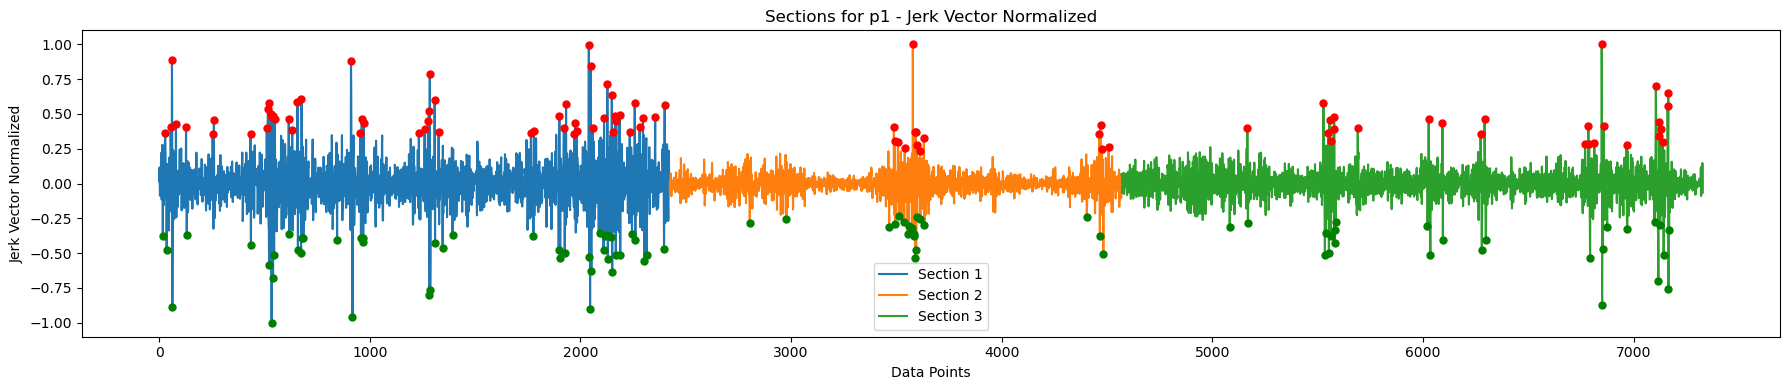

Mean value for section_1: 0.2506289487999987
Number of positive peaks in section_1: 39
Number of negative peaks in section_1: 41
Mean value for section_2: 0.2695994391810429
Number of positive peaks in section_2: 54
Number of negative peaks in section_2: 65
Mean value for section_3: 0.26142587158699404
Number of positive peaks in section_3: 65
Number of negative peaks in section_3: 56


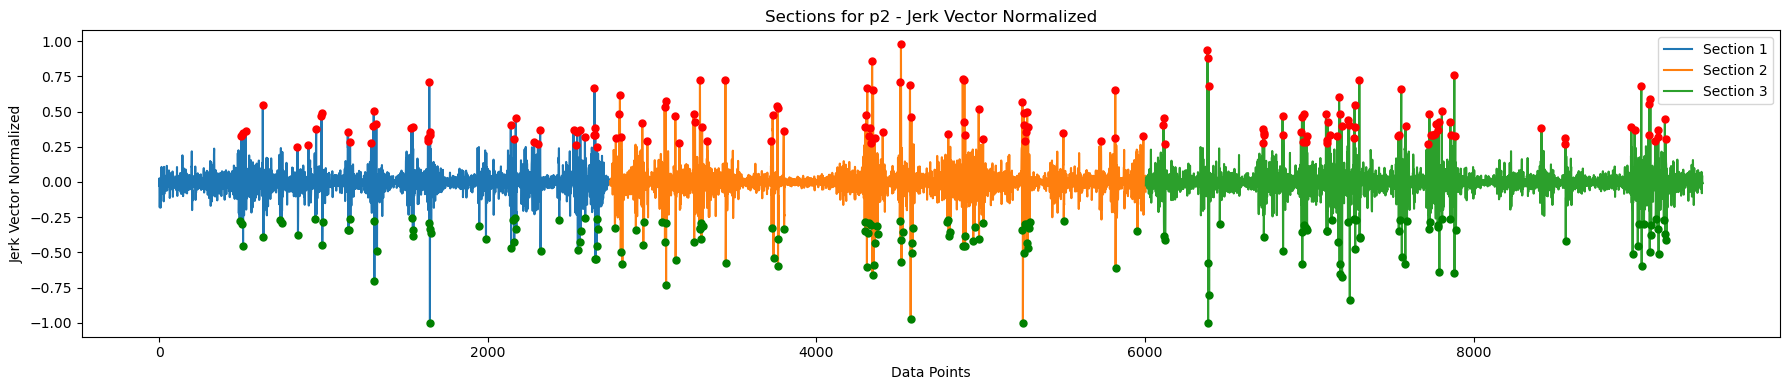

Mean value for section_1: 0.274699638212192
Number of positive peaks in section_1: 27
Number of negative peaks in section_1: 26
Mean value for section_2: 0.22758690055558647
Number of positive peaks in section_2: 23
Number of negative peaks in section_2: 24
Mean value for section_3: 0.23666277469891056
Number of positive peaks in section_3: 24
Number of negative peaks in section_3: 26


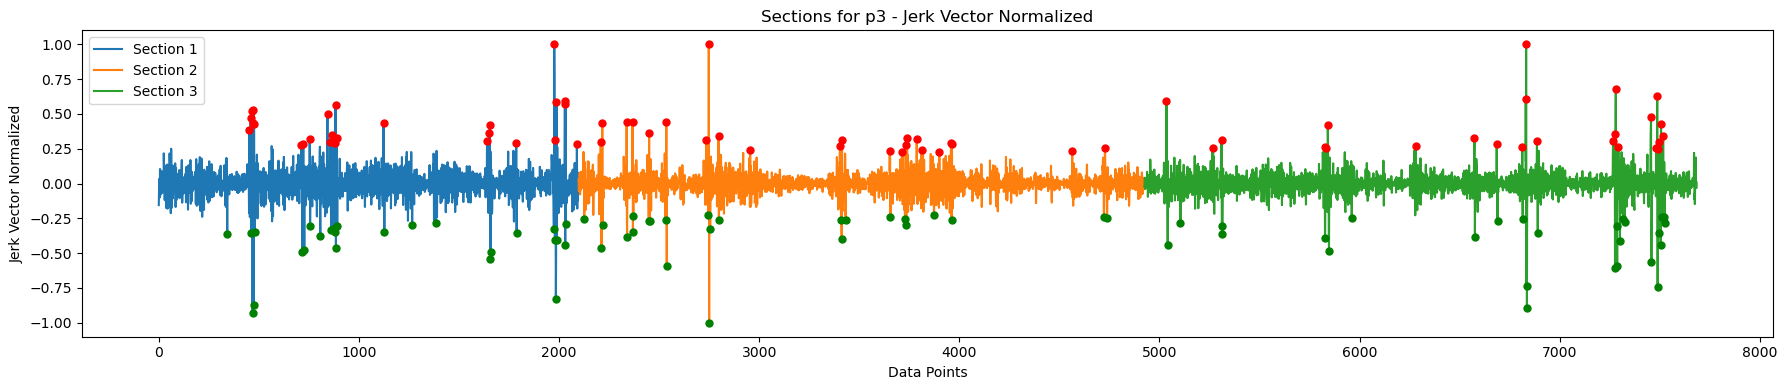

Mean value for section_1: 0.28865299050551413
Number of positive peaks in section_1: 50
Number of negative peaks in section_1: 44
Mean value for section_2: 0.29075789497460613
Number of positive peaks in section_2: 40
Number of negative peaks in section_2: 41
Mean value for section_3: 0.20511055694997346
Number of positive peaks in section_3: 17
Number of negative peaks in section_3: 22


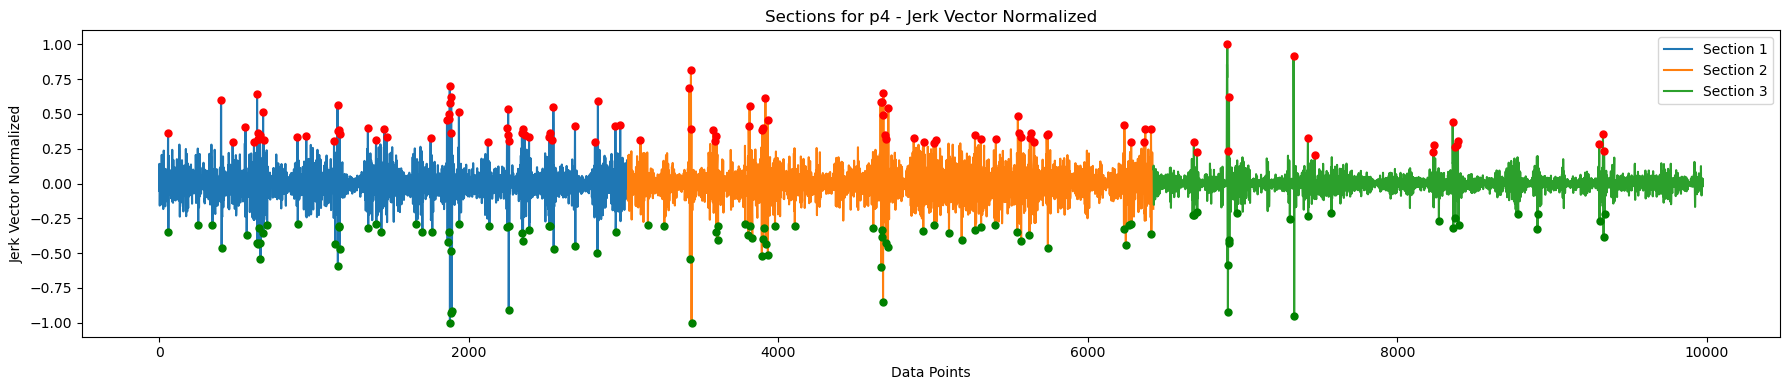

Mean value for section_1: 0.3524580130133567
Number of positive peaks in section_1: 35
Number of negative peaks in section_1: 33
Mean value for section_2: 0.3096693698573101
Number of positive peaks in section_2: 34
Number of negative peaks in section_2: 33
Mean value for section_3: 0.3642945137026723
Number of positive peaks in section_3: 31
Number of negative peaks in section_3: 35


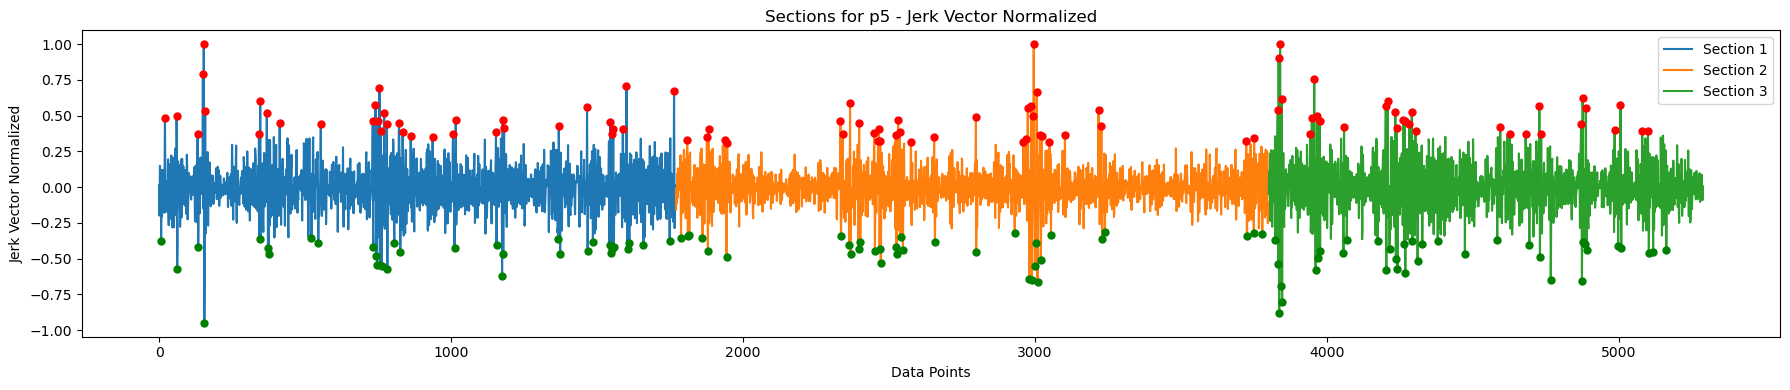

Mean value for section_1: 0.35072755981777
Number of positive peaks in section_1: 37
Number of negative peaks in section_1: 43
Mean value for section_2: 0.35624648603689474
Number of positive peaks in section_2: 49
Number of negative peaks in section_2: 46
Mean value for section_3: 0.3730129443983503
Number of positive peaks in section_3: 65
Number of negative peaks in section_3: 59


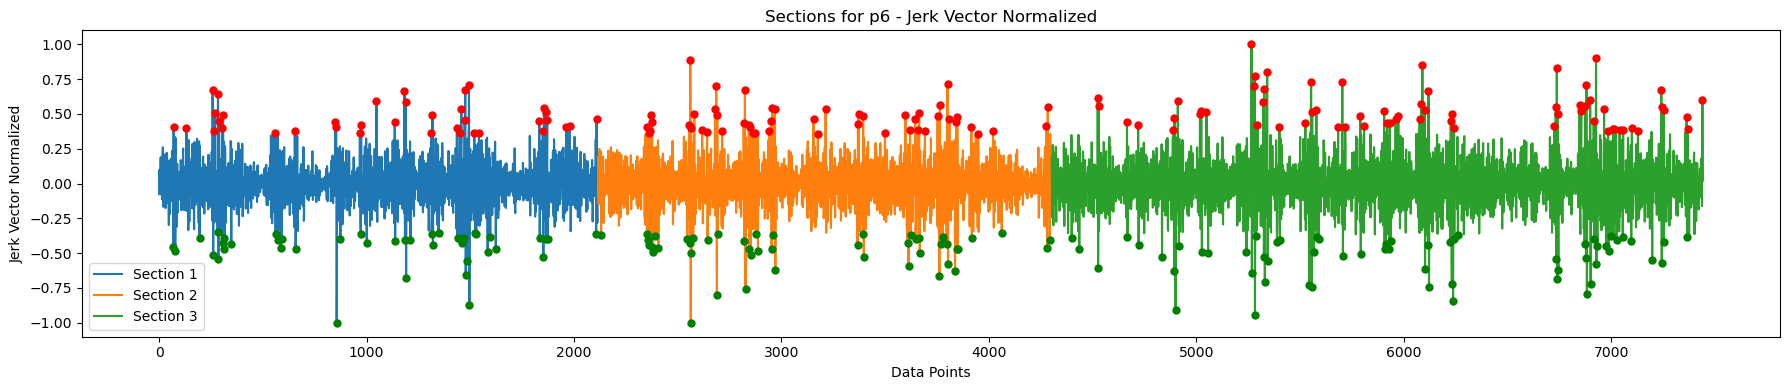

Mean value for section_1: 0.34180500969334165
Number of positive peaks in section_1: 39
Number of negative peaks in section_1: 40
Mean value for section_2: 0.3984318095404635
Number of positive peaks in section_2: 75
Number of negative peaks in section_2: 72
Mean value for section_3: 0.342381130212896
Number of positive peaks in section_3: 47
Number of negative peaks in section_3: 55


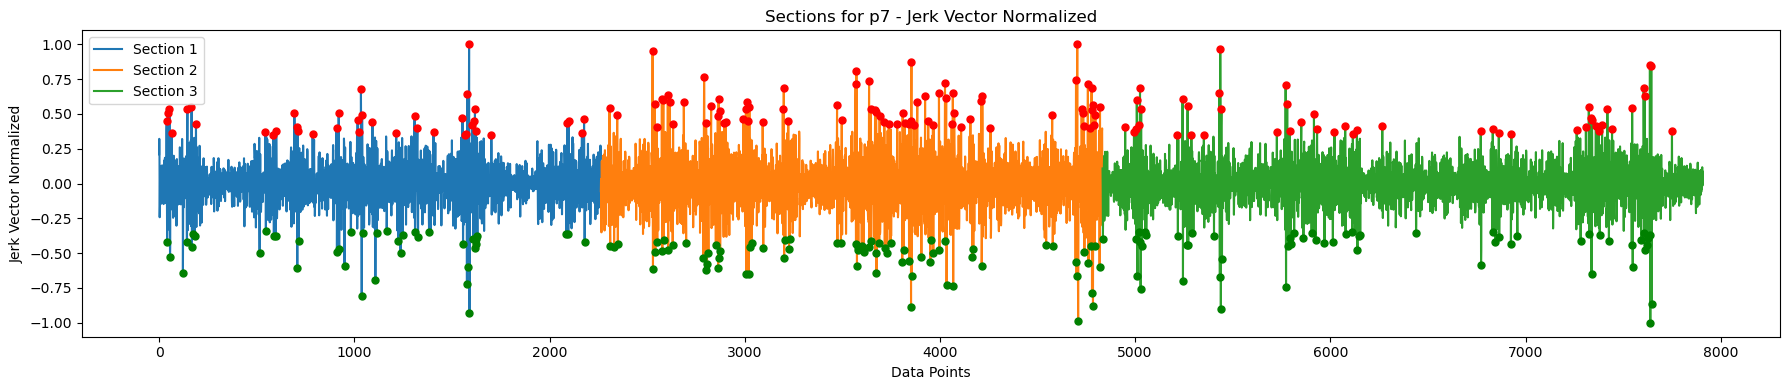

Mean value for section_1: 0.2098672294686417
Number of positive peaks in section_1: 15
Number of negative peaks in section_1: 19
Mean value for section_2: 0.19652014751091096
Number of positive peaks in section_2: 32
Number of negative peaks in section_2: 27
Mean value for section_3: 0.14460606224934472
Number of positive peaks in section_3: 14
Number of negative peaks in section_3: 13


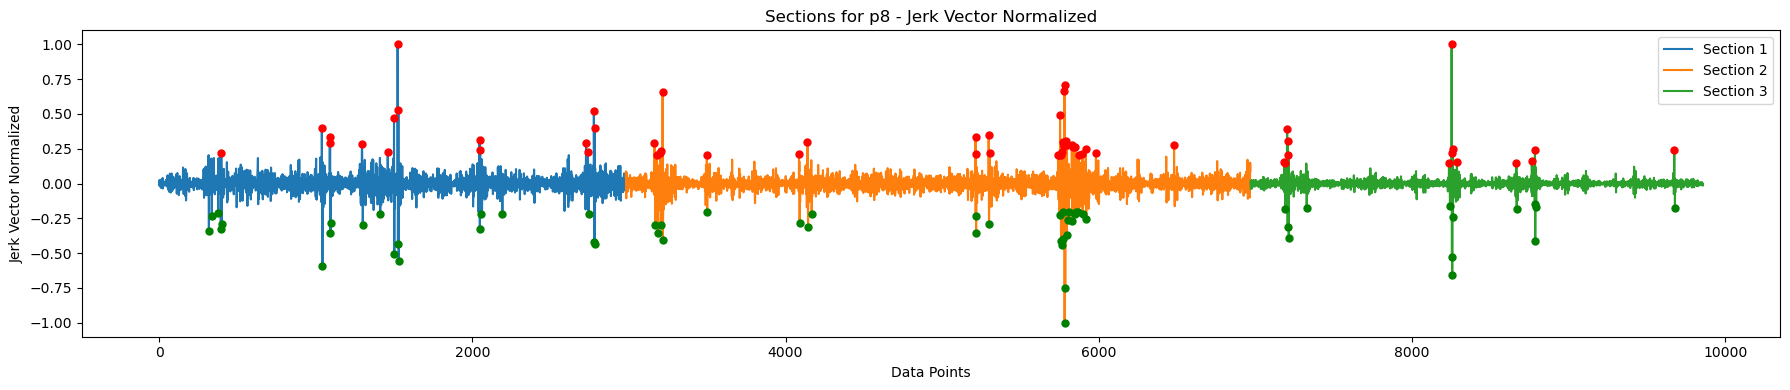

Mean value for section_1: 0.2334028488892606
Number of positive peaks in section_1: 16
Number of negative peaks in section_1: 9
Mean value for section_2: 0.3529174990663158
Number of positive peaks in section_2: 39
Number of negative peaks in section_2: 33
Mean value for section_3: 0.34272444425322435
Number of positive peaks in section_3: 30
Number of negative peaks in section_3: 32


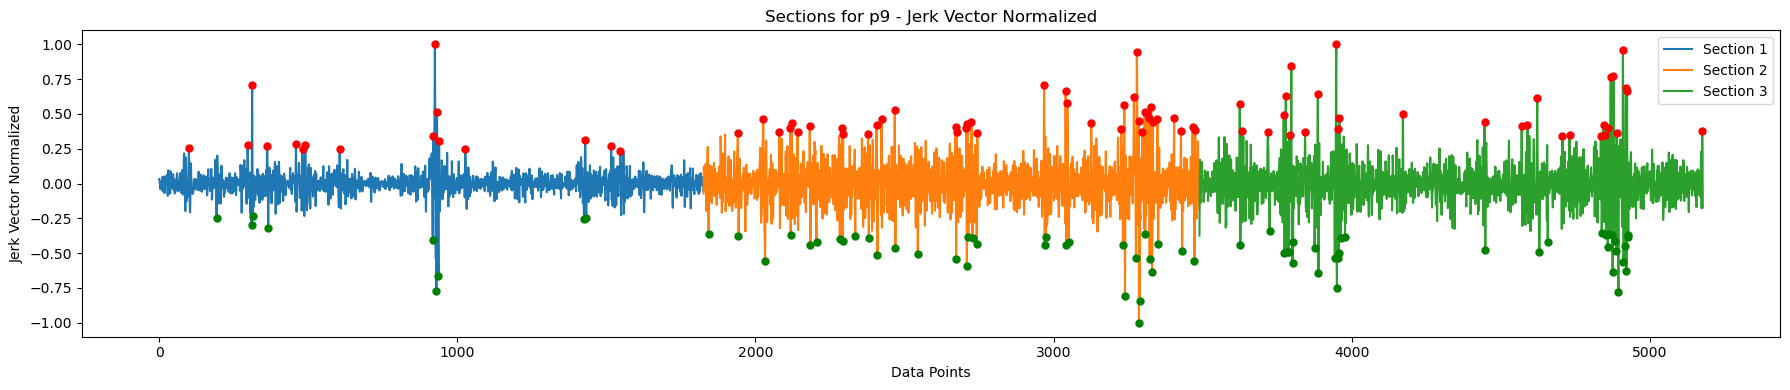

Mean value for section_1: 0.364627652784637
Number of positive peaks in section_1: 55
Number of negative peaks in section_1: 58
Mean value for section_2: 0.25439917291027153
Number of positive peaks in section_2: 29
Number of negative peaks in section_2: 28
Mean value for section_3: 0.2738641307859582
Number of positive peaks in section_3: 34
Number of negative peaks in section_3: 38


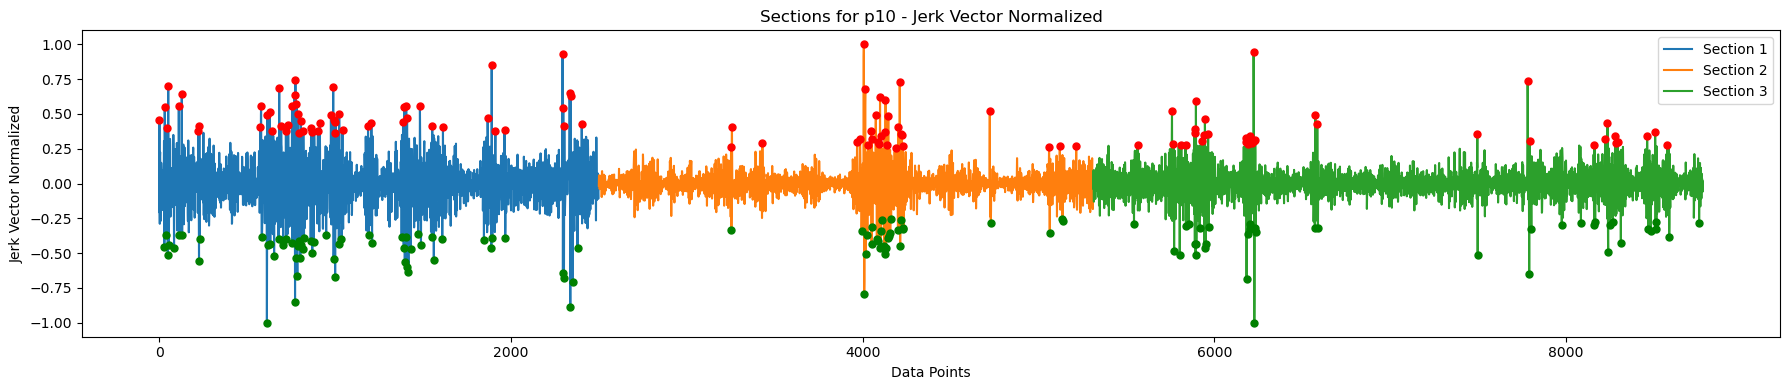

Mean value for section_1: 0.28601257275771835
Number of positive peaks in section_1: 37
Number of negative peaks in section_1: 25
Mean value for section_2: 0.28524753049288615
Number of positive peaks in section_2: 31
Number of negative peaks in section_2: 35
Mean value for section_3: 0.38661132664485337
Number of positive peaks in section_3: 74
Number of negative peaks in section_3: 64


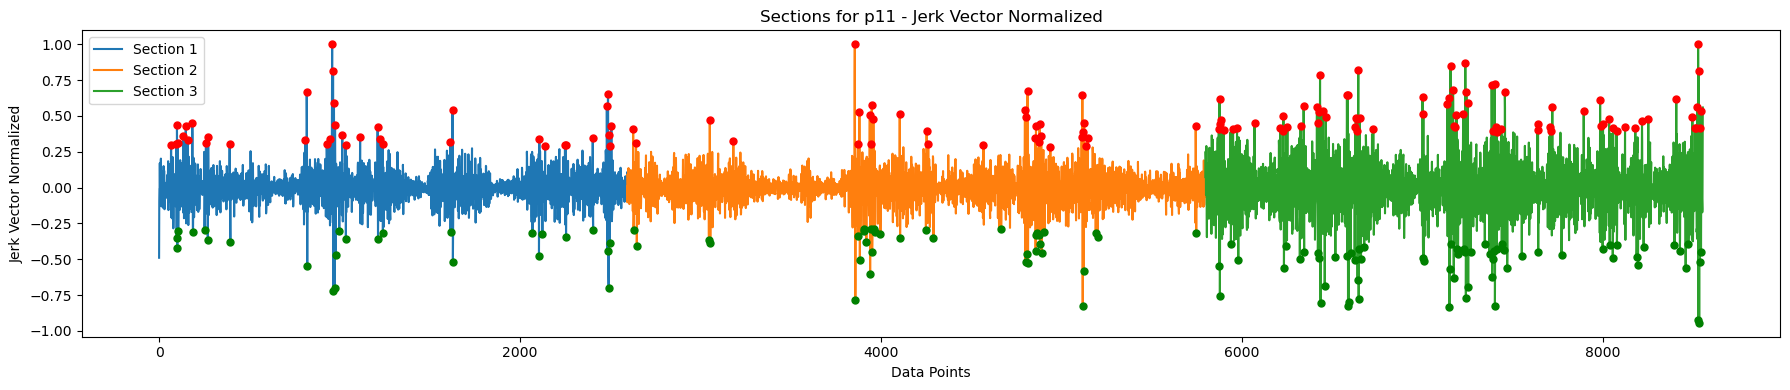

Mean value for section_1: 0.15351610306065863
Number of positive peaks in section_1: 12
Number of negative peaks in section_1: 15
Mean value for section_2: 0.17231555418612873
Number of positive peaks in section_2: 19
Number of negative peaks in section_2: 17
Mean value for section_3: 0.21022608725056763
Number of positive peaks in section_3: 23
Number of negative peaks in section_3: 21


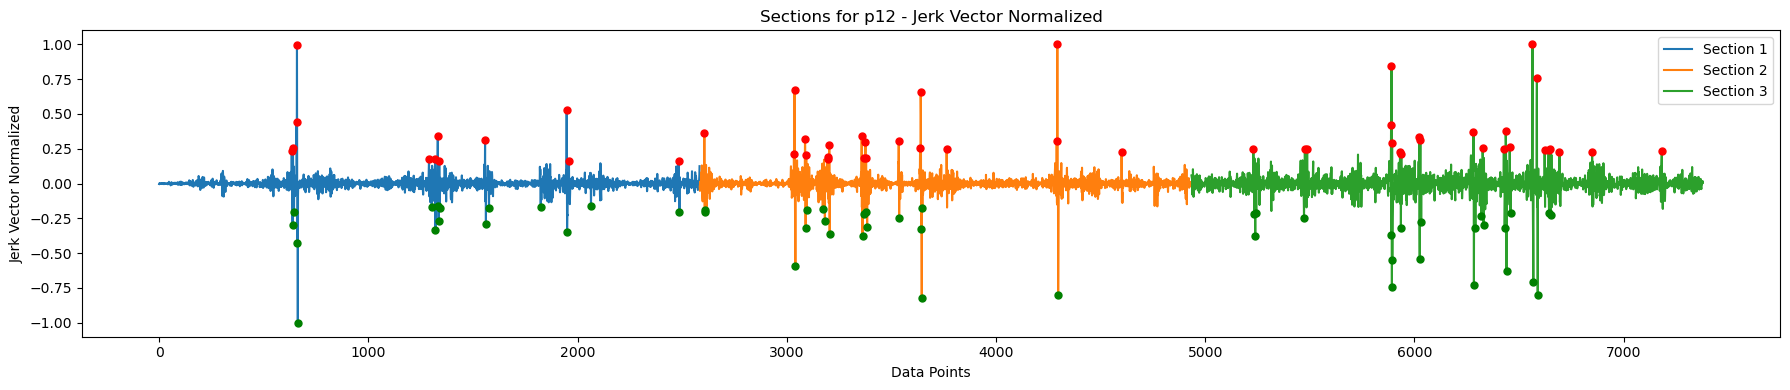

Mean value for section_1: 0.3631466754600165
Number of positive peaks in section_1: 31
Number of negative peaks in section_1: 32
Mean value for section_2: 0.2410366163893918
Number of positive peaks in section_2: 9
Number of negative peaks in section_2: 11
Mean value for section_3: 0.38078482483532083
Number of positive peaks in section_3: 40
Number of negative peaks in section_3: 37


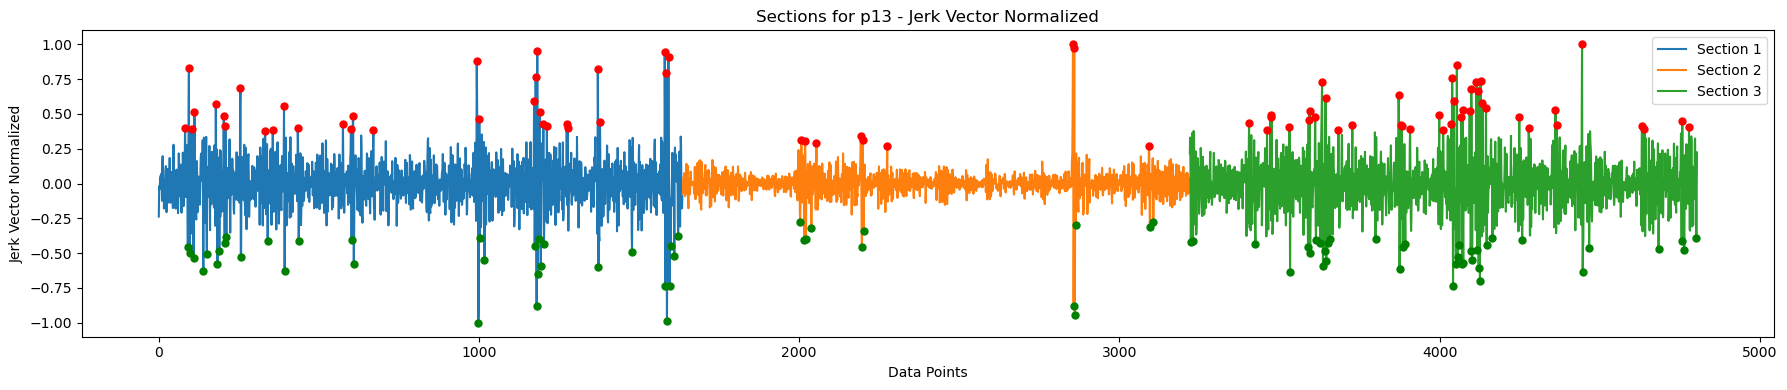

Mean value for section_1: 0.3813515678558865
Number of positive peaks in section_1: 33
Number of negative peaks in section_1: 38
Mean value for section_2: 0.27410242868844953
Number of positive peaks in section_2: 15
Number of negative peaks in section_2: 16
Mean value for section_3: 0.2646534300649439
Number of positive peaks in section_3: 17
Number of negative peaks in section_3: 20


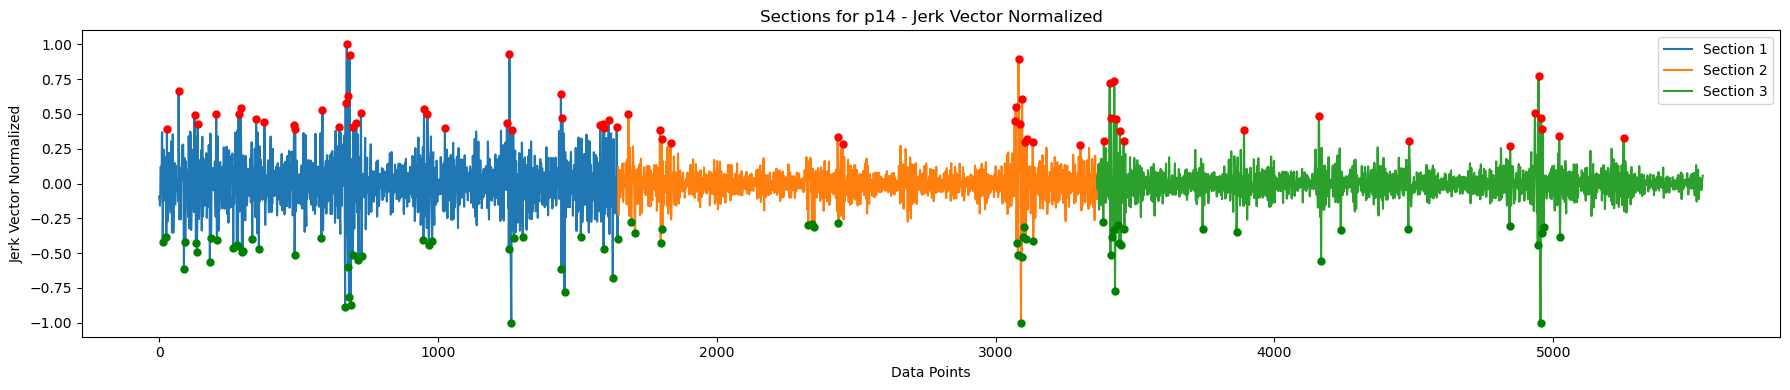

Mean value for section_1: 0.3471734112996694
Number of positive peaks in section_1: 75
Number of negative peaks in section_1: 79
Mean value for section_2: 0.30893774400809926
Number of positive peaks in section_2: 50
Number of negative peaks in section_2: 49
Mean value for section_3: 0.3012424053550807
Number of positive peaks in section_3: 43
Number of negative peaks in section_3: 46


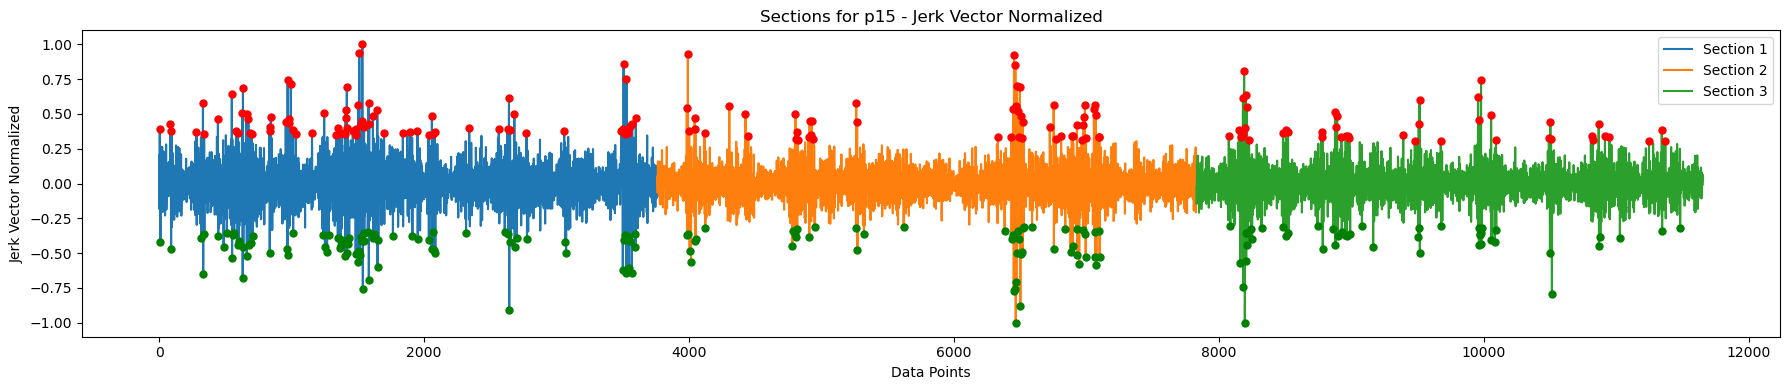

Mean value for section_1: 0.2640564237589062
Number of positive peaks in section_1: 31
Number of negative peaks in section_1: 31
Mean value for section_2: 0.16229570267508903
Number of positive peaks in section_2: 20
Number of negative peaks in section_2: 21
Mean value for section_3: 0.25663283165269823
Number of positive peaks in section_3: 35
Number of negative peaks in section_3: 37


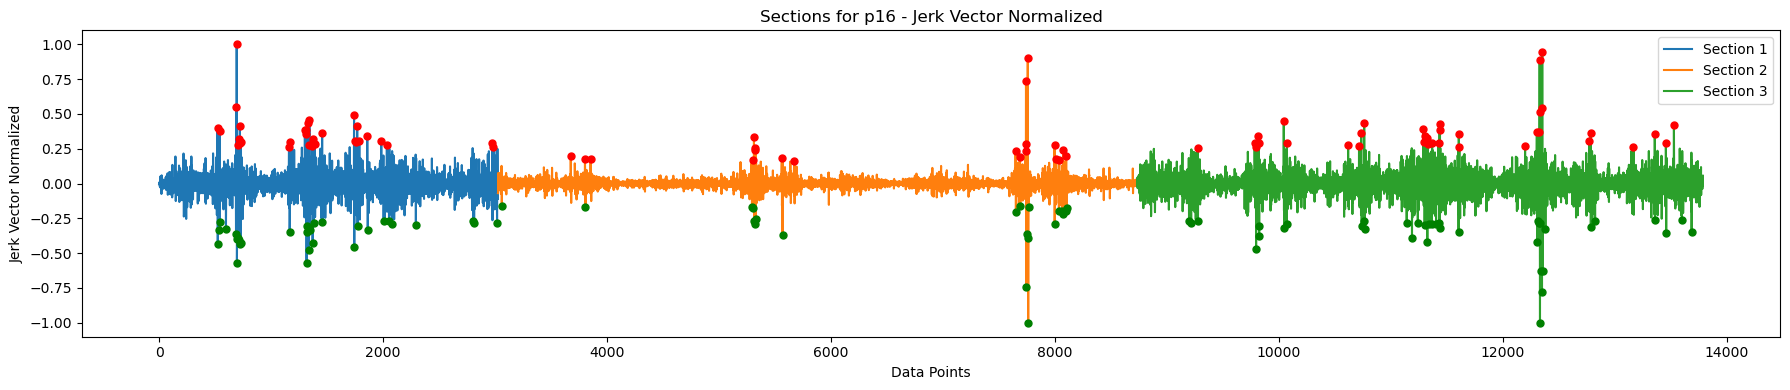

Mean value for section_1: 0.277379035576781
Number of positive peaks in section_1: 31
Number of negative peaks in section_1: 24
Mean value for section_2: 0.1883427508669303
Number of positive peaks in section_2: 11
Number of negative peaks in section_2: 13
Mean value for section_3: 0.20913147747217223
Number of positive peaks in section_3: 11
Number of negative peaks in section_3: 5


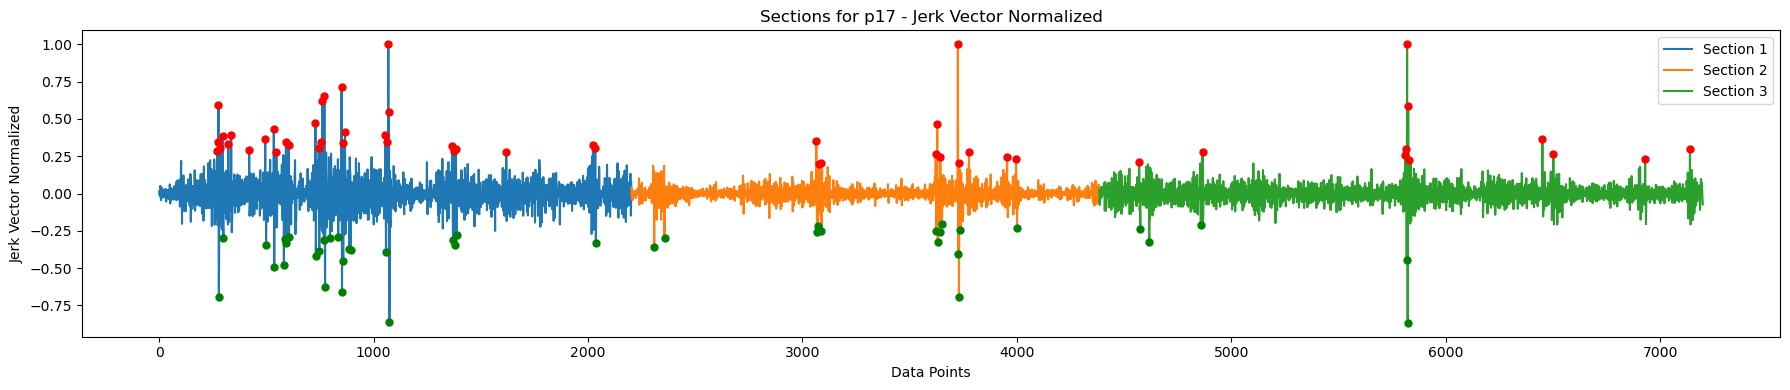

Mean value for section_1: 0.22710906118593266
Number of positive peaks in section_1: 14
Number of negative peaks in section_1: 13
Mean value for section_2: 0.32885154839514713
Number of positive peaks in section_2: 39
Number of negative peaks in section_2: 34
Mean value for section_3: 0.26222287337028166
Number of positive peaks in section_3: 33
Number of negative peaks in section_3: 29


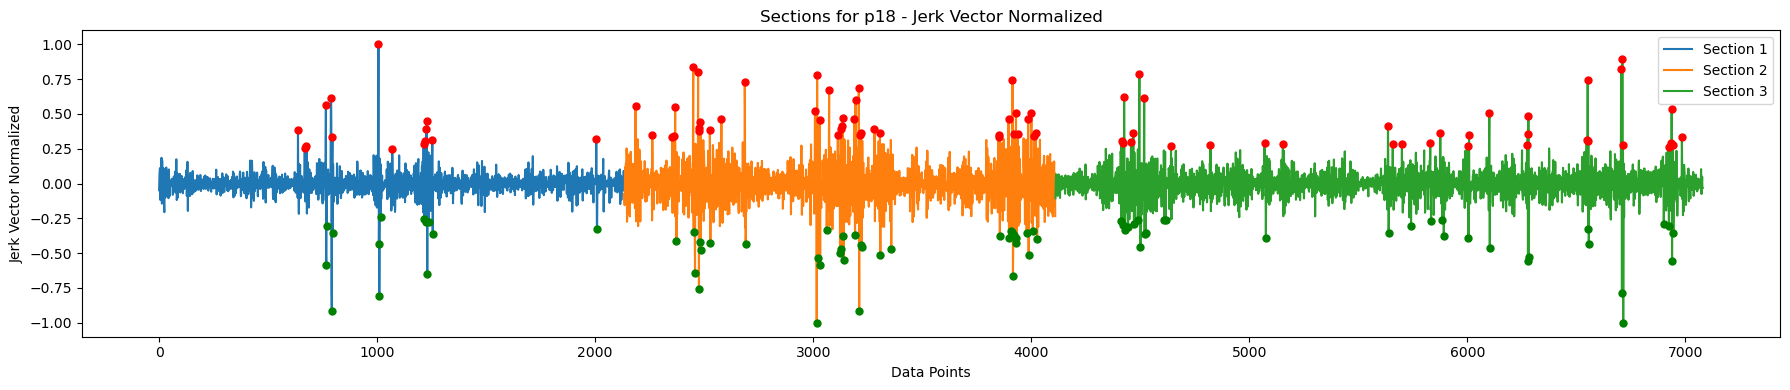

In [13]:
def find_and_plot_peaks(data, mean, label):
    mean_scalar = np.sqrt(mean.values.item())  
    print(f"Mean value for {label}: {mean_scalar}")

    # Find positive peaks
    pos_peaks, _ = find_peaks(data, height=mean_scalar, prominence=0.1) 
    num_pos_peaks = len(pos_peaks)
    print(f"Number of positive peaks in {label}: {num_pos_peaks}")
    plt.plot(pos_peaks, data[pos_peaks], 'ro', markersize=5) 
    
    # Find negative peaks
    neg_peaks, _ = find_peaks(-data, height=mean_scalar, prominence=0.1)  
    num_neg_peaks = len(neg_peaks)
    print(f"Number of negative peaks in {label}: {num_neg_peaks}")
    plt.plot(neg_peaks, data[neg_peaks], 'go', markersize=5) 

    # Save 
    acc_data[f'{label}_pos_peaks'] = num_pos_peaks
    acc_data[f'{label}_neg_peaks'] = num_neg_peaks

for person_name, acc_data in acc_dict.items():
    section1_data = acc_data['section_1_normalized']
    section2_data = acc_data['section_2_normalized']
    section3_data = acc_data['section_3_normalized']
    section1_mean = np.mean(np.abs(section1_data))
    section2_mean = np.mean(np.abs(section2_data))
    section3_mean = np.mean(np.abs(section3_data))
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 4))
    ax.plot(section1_data, label='Section 1')
    ax.plot(section2_data, label='Section 2')
    ax.plot(section3_data, label='Section 3')
    ax.set_title(f'Sections for {person_name} - Jerk Vector Normalized')
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Jerk Vector Normalized')
    ax.legend()
    
    # Find and plot peaks for each section
    for section_data, section_mean, section_label in zip([section1_data, section2_data, section3_data], [section1_mean, section2_mean, section3_mean], ['section_1', 'section_2', 'section_3']):
        find_and_plot_peaks(section_data, section_mean, section_label)
    
    plt.tight_layout()
    plt.show()


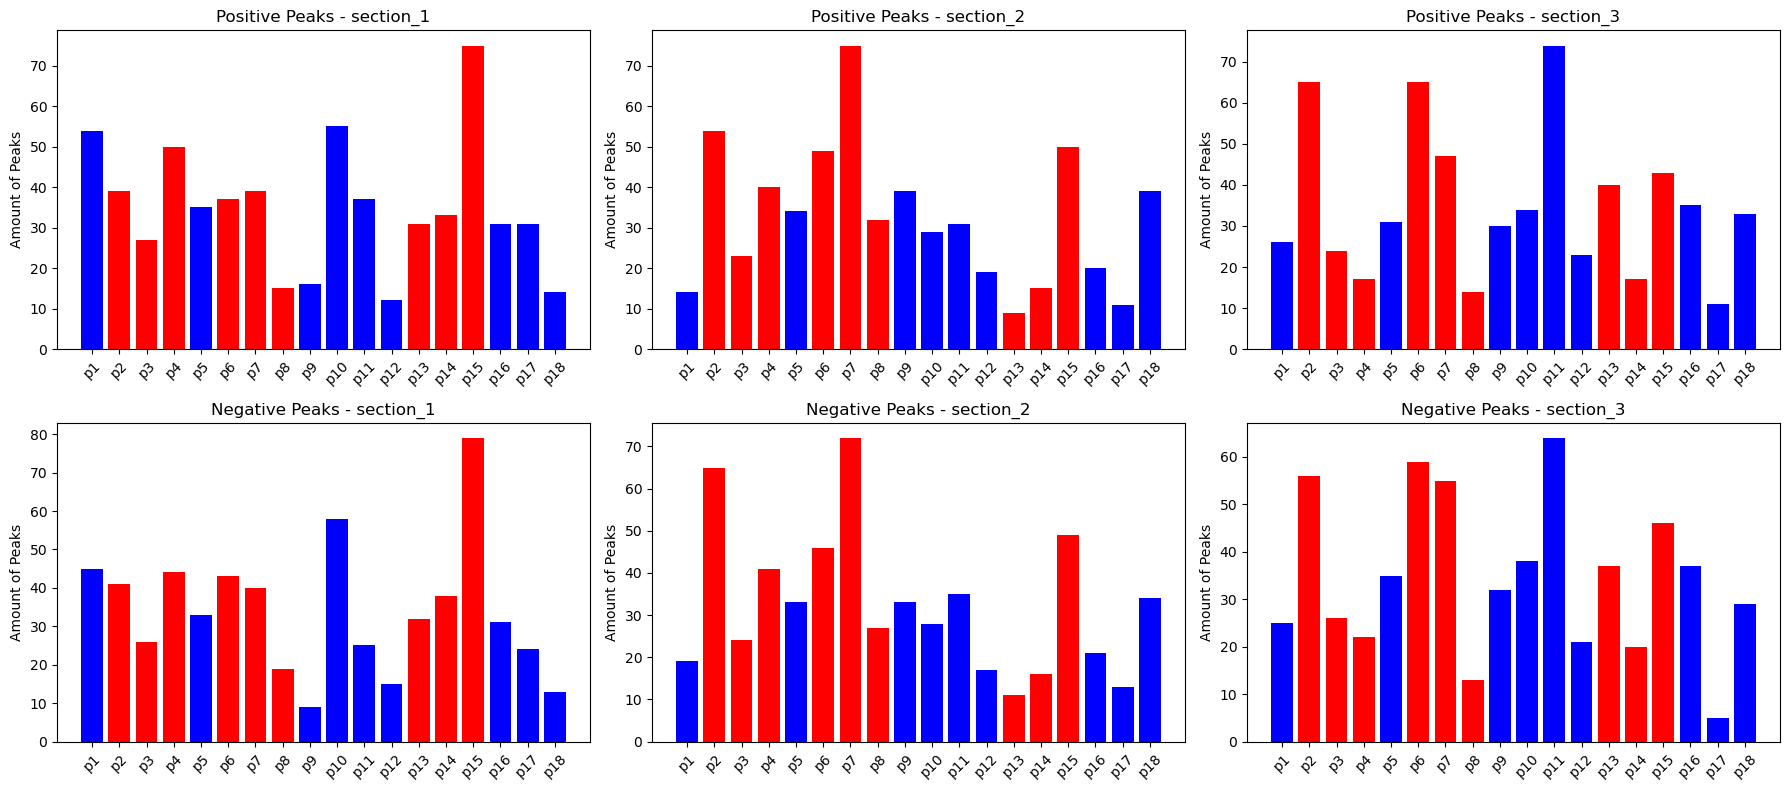

In [14]:
# Initialize 
positive_peak_counts = {'section_1': [], 'section_2': [], 'section_3': []}
negative_peak_counts = {'section_1': [], 'section_2': [], 'section_3': []}

for person_name, acc_data in acc_dict.items():
    for section_label in ['section_1', 'section_2', 'section_3']:
        positive_peak_count_key = f'{section_label}_pos_peaks'
        negative_peak_count_key = f'{section_label}_neg_peaks'
        
        positive_peak_count = acc_data.get(positive_peak_count_key, 0)
        negative_peak_count = acc_data.get(negative_peak_count_key, 0)

        positive_peak_counts[section_label].append(positive_peak_count)
        negative_peak_counts[section_label].append(negative_peak_count)

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Positive Peaks
for i, section_label in enumerate(['section_1', 'section_2', 'section_3']):
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    ax = axes[0, i]
    ax.bar(np.arange(len(positive_peak_counts[section_label])), positive_peak_counts[section_label], color=colors)
    ax.set_title(f'Positive Peaks - {section_label}')
    ax.set_ylabel('Amount of Peaks')
    ax.set_xticks(np.arange(len(positive_peak_counts[section_label])))
    ax.set_xticklabels(acc_dict.keys(), rotation=45)

# Negative Peaks
for i, section_label in enumerate(['section_1', 'section_2', 'section_3']):
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    ax = axes[1, i]
    ax.bar(np.arange(len(negative_peak_counts[section_label])), negative_peak_counts[section_label], color=colors)
    ax.set_title(f'Negative Peaks - {section_label}')
    ax.set_ylabel('Amount of Peaks')
    ax.set_xticks(np.arange(len(negative_peak_counts[section_label])))
    ax.set_xticklabels(acc_dict.keys(), rotation=45)

plt.tight_layout()
plt.show()

# Feature Grasping

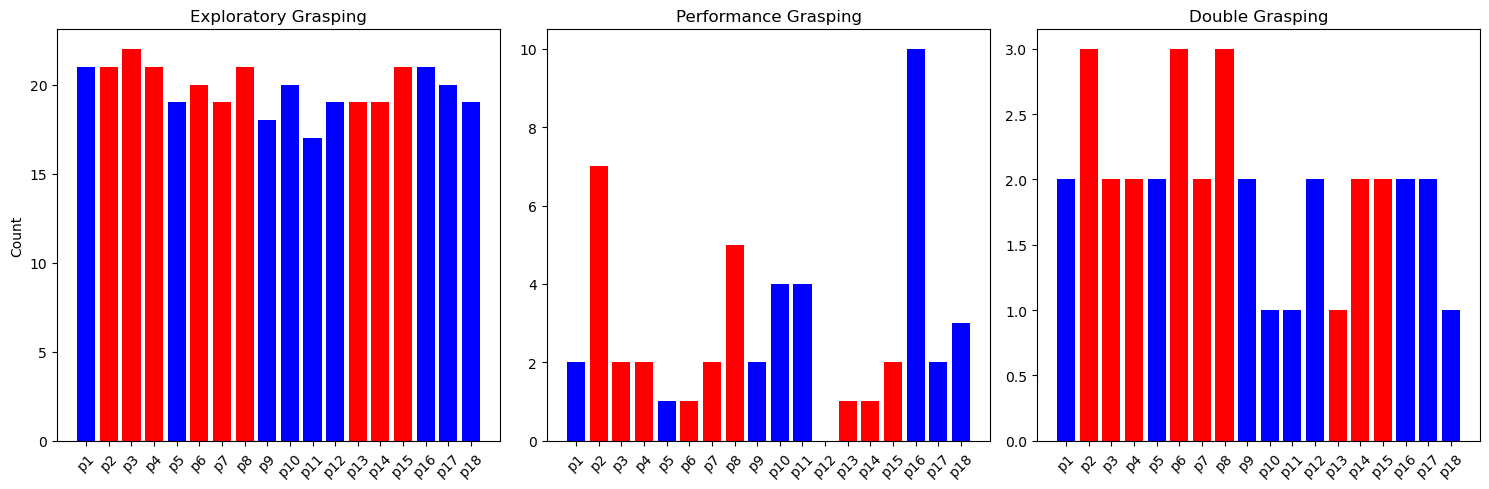

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, grasping_type in enumerate(['grasping_exploratory', 'grasping_performance', 'grasping_double']):
    grasping_values = [acc_dict[person_name][grasping_type] for person_name in person_names]
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    ax = axes[i]
    for person_name, grasping_value, gender in zip(person_names, grasping_values, genders):
        color = 'blue' if gender == 'male' else 'red'
        ax.bar(person_name, grasping_value, color=color)
    
    ax.set_title(f'{grasping_type.split("_")[1].capitalize()} Grasping')
    ax.tick_params(axis='x', rotation=45)

axes[0].set_ylabel('Count')
plt.tight_layout()
plt.show()

# Feature Ascent Time

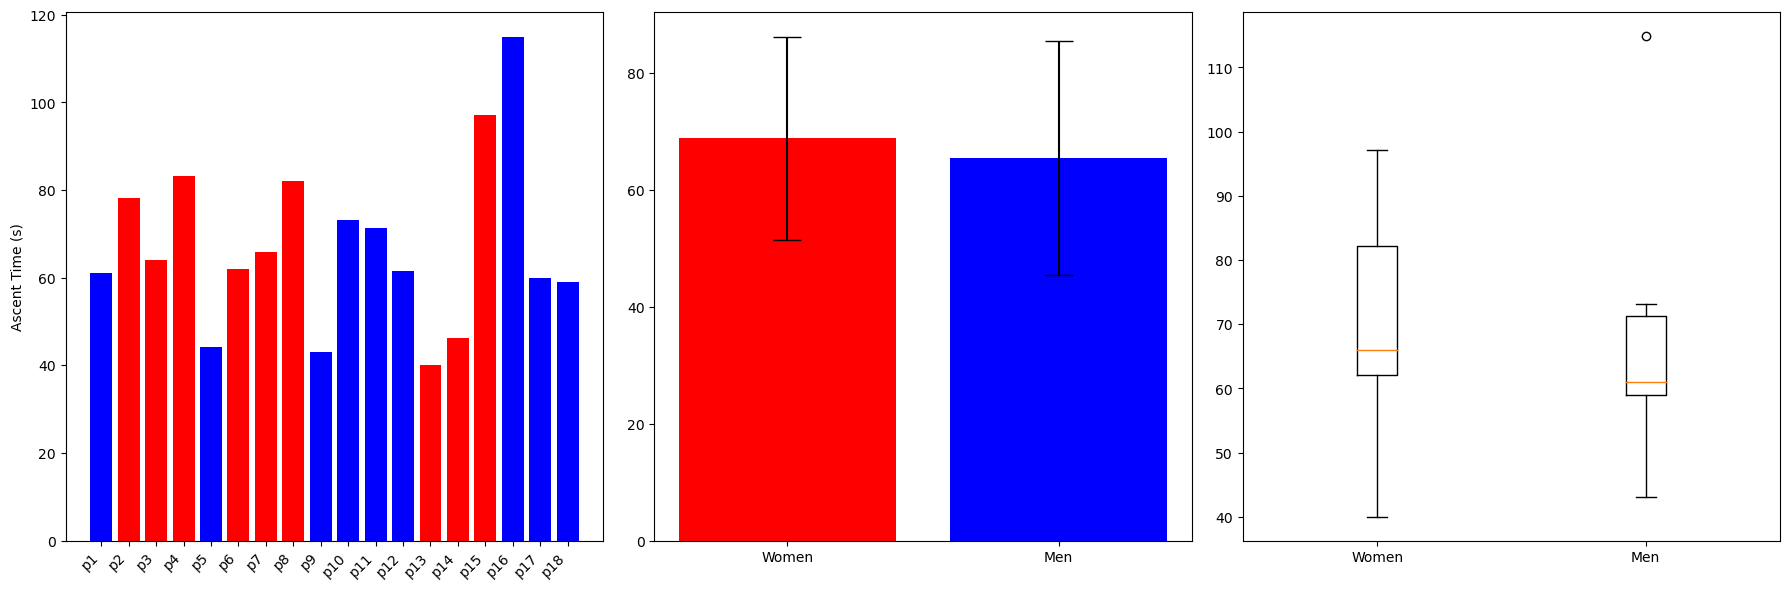

In [38]:
time_values = []
genders = []

for person_name, acc_dataset in acc_dict.items():
    time_values.append(acc_dataset['time'][-1] / 120)  # Convert to seconds
    genders.append(acc_dataset['gender'].values)  # Extract gender values

genders = [str(gender) for gender in genders]

# Calculate mean ascent time for women and men
time_values = np.array(time_values)  
women_times = time_values[np.array(genders) == 'female']
men_times = time_values[np.array(genders) == 'male']

mean_ascent_time_women = np.mean(women_times)
mean_ascent_time_men = np.mean(men_times)

std_ascent_time_women = np.std(women_times)
std_ascent_time_men = np.std(men_times)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

colors = {'male': 'blue', 'female': 'red'}
for person_name, time, gender in zip(person_names, time_values, genders):
    axs[0].bar(person_name, time, color=colors[gender])
axs[0].set_ylabel('Ascent Time (s)')
axs[0].set_xticks(np.arange(len(person_names)))
axs[0].set_xticklabels(person_names, rotation=45, ha='right')

labels = ['Women', 'Men']
mean_values = [mean_ascent_time_women, mean_ascent_time_men]
std_values = [std_ascent_time_women, std_ascent_time_men]
axs[1].bar(labels, mean_values, yerr=std_values, capsize=10, color=['red', 'blue'])

axs[2].boxplot([women_times, men_times], labels=['Women', 'Men'])

plt.tight_layout()
plt.show()


# Export Data
## Jerk

In [39]:
%store acc_dict

Stored 'acc_dict' (dict)


In [ ]:
filename = "jerk_sections.csv"

# Combine mean and standard deviation values for women and men
summary_data = {
    "Axis": [],
    "Jerk_Women": [],
    "Jerk_Men": []
}

# Append the data for each axis
for axis in jerk_values_women.keys():
    summary_data["Axis"].append(axis)
    summary_data["Jerk_Women"].append(jerk_values_women[axis])
    summary_data["Jerk_Men"].append(jerk_values_men[axis])

# Write data to CSV file
with open(filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=summary_data.keys())
    writer.writeheader()
    for i in range(len(summary_data["Axis"])):
        writer.writerow({key: summary_data[key][i] for key in summary_data.keys()})

print(f"Data exported to {filename}")

Data exported to jerk_sections.csv


## Peaks

In [ ]:
csv_file_path = "peaks_sections.csv"

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Define the CSV writer
    csv_writer = csv.writer(csvfile)
    
    # Write the header row
    csv_writer.writerow(['Person', 'Gender', 'Section 1', 'Section 2', 'Section 3'])
    
    # Iterate over each person
    for person_name, acc_data in acc_dict.items():
        # Extract gender (assuming 'gender' key exists in acc_data)
        gender = 1 if acc_data['gender'] == 'male' else 0
        
        # Extract the number of positive peaks for each section
        section1 = acc_data['section_1_pos_peaks'].item()
        section2 = acc_data['section_2_pos_peaks'].item()
        section3 = acc_data['section_3_pos_peaks'].item()

        positive_peaks_counts = [section1, section2, section3]
        
        # Write the data to the CSV file
        csv_writer.writerow([person_name, gender] + positive_peaks_counts)

print("CSV file exported successfully!")



CSV file exported successfully!
